In [1]:
%load_ext autoreload
%autoreload 2

from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
import json 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy

from src.elastic.helper import get_query, get_query_all, get_query_extend, get_tweet_text

In [3]:
import json 
### metadata
config = None
config_location = "./src/elastic/config.json"
with open(config_location, "r") as f:
    config = json.load(f)
config


{'elasticsearch_host': 'https://localhost:8080',
 'elasticsearch_verify_certs': False,
 'elasticsearch_index_name': 'ukraine-data-lite',
 'elasticsearch_timeout_secs': 120,
 'log_level': 'WARNING'}

In [124]:
nlp = spacy.load("./model/text_classify/gpu_small/model-best")
nlp2 = spacy.load("./model/span_classify/gpu_large_v4_0.2/model-best")

In [125]:
client = Elasticsearch(hosts=[config["elasticsearch_host"]], 
                   verify_certs=config["elasticsearch_verify_certs"],
                   request_timeout=config["elasticsearch_timeout_secs"])

s = Search(using=client, index=config["elasticsearch_index_name"])
s = s.params(size=10000, scroll='120m')
s.update_from_dict(get_query_extend())
get_query_extend()

{'_source': ['created_at',
  'text',
  'full_text',
  'extended_tweet.full_text',
  'quoted_status.text',
  'quoted_status.full_text',
  'quoted_status.extended_tweet.full_text',
  'sentiment.roberta.primary',
  'sentiment.roberta.quoted',
  'embedding.sbert.primary'],
 'query': {'bool': {'filter': [{'bool': {'must_not': {'exists': {'field': 'retweeted_status.id'}}}}]}}}

In [126]:
### testing the classification model
doc = nlp("I love 5 coffee")
for word in doc:
    lexeme = doc.vocab[word.text]
    print("===============")
    print("text: ", lexeme.text)
    print("orth: ", lexeme.orth)
    print("shape: ", lexeme.shape_)
    print("prefix: ", lexeme.prefix_)
    print("suffix: ", lexeme.suffix_)
    print("is_alpha: ", lexeme.is_alpha)
    print("is_digit: ", lexeme.is_digit)
    print("is_title: ", lexeme.is_title)
    print("lang_: ", lexeme.lang_)
    print("lang_: ", word.pos_)
    print("lang_: ", word.shape_)
print("cats: ", doc.cats)
    

text:  I
orth:  4690420944186131903
shape:  X
prefix:  I
suffix:  I
is_alpha:  True
is_digit:  False
is_title:  True
lang_:  en
lang_:  
lang_:  X
text:  love
orth:  3702023516439754181
shape:  xxxx
prefix:  l
suffix:  ove
is_alpha:  True
is_digit:  False
is_title:  False
lang_:  en
lang_:  
lang_:  xxxx
text:  5
orth:  2090661578966068036
shape:  d
prefix:  5
suffix:  5
is_alpha:  False
is_digit:  True
is_title:  False
lang_:  en
lang_:  
lang_:  d
text:  coffee
orth:  3197928453018144401
shape:  xxxx
prefix:  c
suffix:  fee
is_alpha:  True
is_digit:  False
is_title:  False
lang_:  en
lang_:  
lang_:  xxxx
cats:  {'Appeal to authority': 0.008453178219497204, 'Appeal to fear/prejudice': 0.0002152788219973445, 'Black-and-white Fallacy/Dictatorship': 0.002359614474698901, 'Causal Oversimplification': 0.0026957367081195116, 'Doubt': 0.0019473066786304116, 'Exaggeration/Minimisation': 0.0030646927189081907, 'Flag-waving': 0.004875794518738985, 'Glittering generalities (Virtue)': 0.00059128

In [127]:
label_path = "./data/raw/sem_eval_task6/valid_label.txt"
with open(label_path, 'r', encoding="utf-8") as input_file:
    categories = input_file.read().strip().split("\n")
categories


['Appeal to authority',
 'Appeal to fear/prejudice',
 'Black-and-white Fallacy/Dictatorship',
 'Causal Oversimplification',
 'Doubt',
 'Exaggeration/Minimisation',
 'Flag-waving',
 'Glittering generalities (Virtue)',
 'Loaded Language',
 "Misrepresentation of Someone's Position (Straw Man)",
 'Name calling/Labeling',
 'Obfuscation, Intentional vagueness, Confusion',
 'Presenting Irrelevant Data (Red Herring)',
 'Reductio ad hitlerum',
 'Repetition',
 'Slogans',
 'Smears',
 'Thought-terminating cliché',
 'Whataboutism',
 'Bandwagon']

In [128]:
df_columns = ["date", 
              "text", 
              "quote_text", 
              "text_word_count", 
              "text_token_count", 
              "sentiment_primary", 
              "sentiment_quoted",
              "span_count",
              "conf_class",
              "conf_value"]
df_columns = df_columns + categories
embed_matrix = None
data_frame = pd.DataFrame(columns=df_columns)
span_record = pd.DataFrame(columns=['data_index', 'class', 'size', 'text'])
token_corpus = []
pruned_token_corpus = []
span_doc_list = []


### begin grabbing the data
max_entry = 10000
i = 0
for hit in s.scan():
    date, text, quoted_text, sentiment_primary, sentiment_quoted, embedding = get_tweet_text(hit)
    date_time = pd.to_datetime(date)
    if embed_matrix is None:
        embed_matrix = embedding
    else:
        embed_matrix = np.vstack((embed_matrix,embedding))
        
    ### tokenize and prune stopword
    doc = nlp(text)
    predicted_categories = doc.cats
    doc2 = nlp2(text)
    span_doc_list.append(doc2)
    span_list = doc2.spans["sc"]

    token_list = [token for token in doc if not token.is_stop and not token.is_punct and not token.text.isspace()]
    pruned_token_list = [token for token in doc if not token.is_punct and not token.text.isspace()]
    token_corpus.append(token_list)
    pruned_token_corpus.append(pruned_token_list)
    
    data_frame.loc[len(data_frame.index)] = [date_time, 
                                             text, 
                                             quoted_text, 
                                             len(text), 
                                             len(token_list), 
                                             sentiment_primary, 
                                             predicted_categories[categories[0]],
                                             len(span_list),
                                             max(predicted_categories, key=predicted_categories.get),
                                             max(predicted_categories.values())] + list(predicted_categories.values())
    for span in doc2.spans["sc"]:
        span_record.loc[len(span_record.index)] = [len(data_frame.index) - 1, span.label_, len(span), span.text]
    
    i = i+ 1
    if i == max_entry:
        break

## Save and Load the parsed dataset

In [129]:
# file_name = "./data_10000.pkl"
# data_frame.to_pickle(file_name)
# file_name_2 = "./spandata_10000.pkl"
# data_frame.to_pickle(file_name)

In [130]:
# data_frame = pd.read_pickle(file_name)

In [131]:
print(len(token_corpus))
embed_matrix.shape

10000


(10000, 384)

In [ ]:
data_frame.head()

In [ ]:
span_record.head()

In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
X = vectorizer.fit_transform(token_corpus) ### use lemma

print(vectorizer.get_feature_names_out())
print(X.shape) # (#entry, #words)
names = vectorizer.get_feature_names_out()
X ##### this is count matrix
count_matrix = pd.DataFrame(X.toarray(), columns = names)
### next, get the correlation matrix and plot the network
print(len(count_matrix), " rows")
count_matrix.head()

/software/anaconda3/envs/rattar_datav6/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[Thanks Huge Putin ... hate propaganda https://t.co/KB570l3NZ4]
(10000, 148509)
10000  rows


,Thanks,Huge,Putin,@PPennypacker,@JoshuaOgundu,Reminder,@JAFERDIAN,@VictorK37694416,UA_struggle,@JerryStillman,...,question,home,thwarting,-0-,free,speech,CCP,hate,propaganda,https://t.co/KB570l3NZ4
0,0.447214,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.267261,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.218218,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.235702,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.288675,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
count_matrix.head()

,Thanks,Huge,Putin,@PPennypacker,@JoshuaOgundu,Reminder,@JAFERDIAN,@VictorK37694416,UA_struggle,@JerryStillman,...,question,home,thwarting,-0-,free,speech,CCP,hate,propaganda,https://t.co/KB570l3NZ4
0,0.447214,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.267261,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.218218,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.235702,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.288675,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
count_matrix.shape

(10000, 148509)

In [137]:
# prune the data
top_k = int(0.1 * count_matrix.shape[1])
column_count = count_matrix.sum().sort_values(ascending=False)
# column_count = count_matrix.sum()
count_matrix_reduced = count_matrix.loc[:,column_count.index]
count_matrix_reduced = count_matrix_reduced.iloc[:, :top_k]
# count_matrix_reduced = count_matrix[count_matrix.columns[count_matrix.sum()>1]]
print("before reduce: ", count_matrix.shape)
print("after reduce: ", count_matrix_reduced.shape)


before reduce:  (10000, 148509)
after reduce:  (10000, 14850)


## For calculating + draw correlation network
(got commented out because memory limit)

In [138]:
# corr = count_matrix_reduced.corr()
# links = corr.stack().reset_index()
# links.columns = ['var1', 'var2', 'value']
# print("all links shape: ", links.shape)

In [139]:
# print(links.shape)
# print(links.loc[links['value'] > 0.1].shape)
# print(links.loc[links['value'] > 0.2].shape)
# print(links.loc[links['value'] > 0.5].shape)
# print(links.loc[links['value'] > 0.75].shape)
# print(links.loc[links['value'] > 0.9].shape)
# print(links.loc[links['value'] > 0.95].shape)
# print(links.loc[links['value'] > 0.99].shape)
# print(links.loc[links['value'] == 1].shape)

In [140]:
# threshold = 0.5
# links_filtered=links.loc[ (links['value'] > threshold) & (links['var1'] != links['var2']) ]
# print("links_filtered shape: ", links_filtered.shape)

In [141]:
# links_filtered

In [142]:
# print("correlation distribution")
# sns.displot(links_filtered, x='value', bins=100)
# sns.displot(links_filtered.loc[links_filtered['value'] != 1], x='value', bins=100)

#### Making correlation network

In [273]:
def get_word_list(count_matrix: pd.DataFrame, print_output=False):
    '''
        input: 
            count_matrix: dataframe from the "vectorizing" function
            excel_index: boolean option indicating whether to transform row index into excel row index
            print_output: boolean option indicating whether to print top k most distinct word
        output: a dictionary with key = unique word, value = list of (row index + 2) of where that word shows up
        ex. "bless": [35,47,49,87] means that word "bless" shows up on row 35,47,49,87
        note: add 2 to chage it from index in dataframe to index in excel file
    '''
    k = 15
    count_dict = {}
    word_list = count_matrix.columns.values
    for word in word_list:
        count_dict[word] = (count_matrix.index[count_matrix[word] > 0]).tolist()
    if print_output == True:
        ### print which word is associated with what rows (in excel)
        # print(json.dumps(count_dict, sort_keys=False, indent=4))

        unqiue_count_dict = {k:len(v) for k, v in count_dict.items()}
        df = pd.DataFrame.from_dict(unqiue_count_dict, orient='index')
        df.columns = ['unique_count']
        ax = df.nlargest(k, 'unique_count').plot.bar(title="tf-idf on unique post", rot=60) ### as in, if word "we" happens 10 times across 4 different post, thhe value will be '4'
        for p in ax.patches:
            ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()))
        #plt.show()

    return count_dict

In [272]:
np.unique(count_matrix_reduced.sum(axis=0))

array([0.33333333, 0.35355339, 0.37796447, 0.40824829, 0.4472136 ,
       0.5       , 0.57735027, 0.70710678, 1.        ])

In [ ]:
count_dict = get_word_list(count_matrix_reduced, print_output=True)

In [145]:
# deg_as_size = False
# plot_type = 'spectral'

# print("pair_corr_plot: making network")
# G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr='value')
# def assign_color(correlation):
#     if correlation <= 0:
#         return "#ffa09b"
#     elif correlation == 1:
#         return "#00e541"
#     else:
#         return "#9eccb7"

# def assign_thickness(correlation, benchmark_thickness=6, scaling_factor=2):
#     return benchmark_thickness * abs(correlation)**scaling_factor

# edge_color = []
# edge_width = []
# for key, value in nx.get_edge_attributes(G, 'value').items():
#     edge_color.append(assign_color(value))
#     edge_width.append(assign_thickness(value))
# node_size = []
# word_dict = get_word_list(count_matrix_reduced)
# print("pair_corr_plot: adjusting node size...")
# if deg_as_size == True:
#     print("using degree as node size...")
# for key, value in dict(G.degree).items():
    
#     if deg_as_size == True:
#         ### value is the degree of the key (a word)
#         scaling_factor = 50
#         node_size.append(value * scaling_factor)
#     else:
#         if plot_type == 'spectral':
#             scaling_factor = 100
#             node_size.append(2*(len(word_dict[key])**2) * scaling_factor)
#         elif plot_type == 'circular':
#                 scaling_factor = 8
#                 node_size.append(2*(len(word_dict[key])**2) * scaling_factor)
#         else:
#             print("plot type is not recognized. received ", plot_type)
#             exit(-1)
        
### trying to draw with networkx
# if plot_type == 'spectral':
#     plt.figure(figsize=(70,70))
#     pos = nx.spring_layout(G, k=0.18, iterations=30)
# elif plot_type == 'circular':
#     plt.figure(figsize=(12,8))
#     pos = nx.circular_layout(G)
# else:
#     print("plot type is not recognized. received ", plot_type)
#     exit(-1)
# print("pair_corr_plot: drawing network")
# nx.draw(G, with_labels=True, pos = pos,node_size=node_size, linewidths=0.5, font_size=15, edge_color=edge_color, width=edge_width)

#### Finding out the best graph parameter

In [146]:
# for size in [70,100,150]:
# # for size in [10]:
#     # for k in [0.15, 0.18, 0.2, 0.22, 0.25]:
#     for k in [0.05,0.08,0.1,0.12]:
#         print("pair_corr_plot: making plot/plot_%.3f_in_%dx%d.png" % (k, size, size))
#         plt.figure(figsize=(size,size))
#         pos = nx.spring_layout(G, k=k, iterations=30)
#         nx.draw(G, with_labels=True, pos = pos,node_size=node_size, linewidths=0.5, font_size=15, edge_color=edge_color, width=edge_width)
#         plt.savefig("plot/plot_%.3f_in_%dx%d.png" % (k, size, size), dpi=10)
#         plt.close()
#         # plt.savefig("plot/plot_%.3f_in_%dx%d.png" % (k, size, size), dpi=100)

# Visualization

## Most confident class (technique classifier)

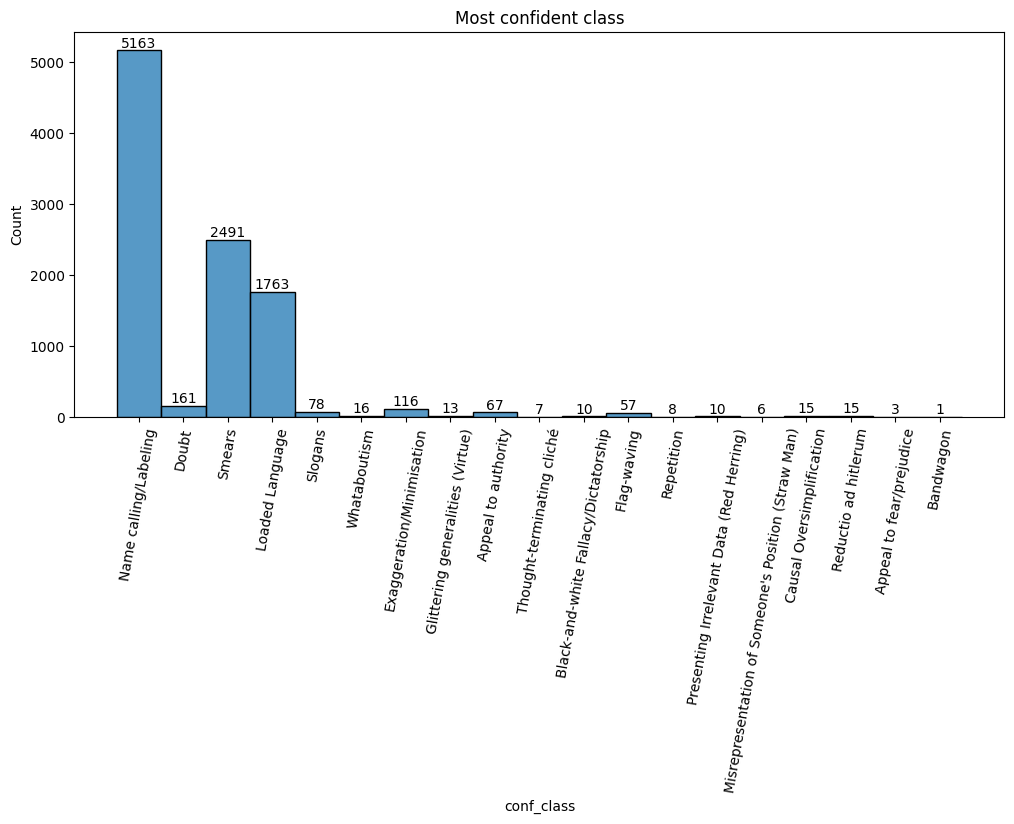

In [284]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
ax = sns.histplot(data_frame, x="conf_class", ax=axes)

for c in ax.containers:
    labels = [f'{v.get_height()}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')  
    
plt.xticks(rotation = 80)
plt.title("Most confident class")
plt.show()

## Span size distribution

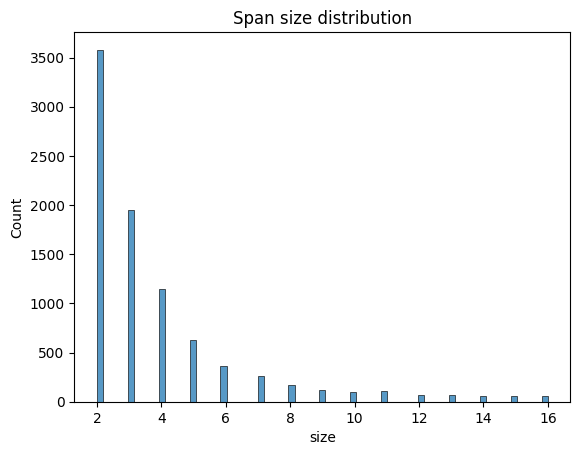

In [148]:
g=sns.histplot(data=span_record, x ="size", legend=False)
plt.title("Span size distribution")
plt.show()

## Span class distribution

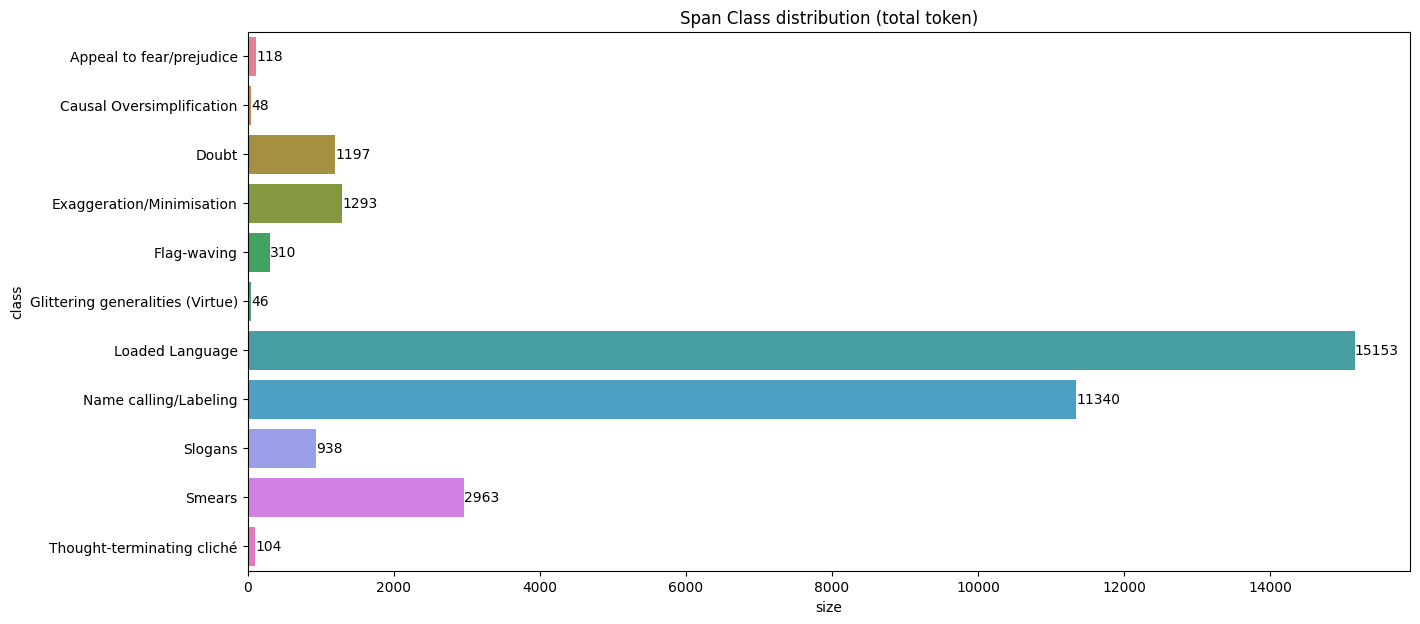

In [149]:
f, ax = plt.subplots(figsize=(15, 7))
g=sns.barplot(data=span_record.groupby('class').sum(), x='size', y='class', hue='class', legend=False)
ax = g
for c in ax.containers:
    labels = [f'{v.get_width():.0f}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')
plt.title("Span Class distribution (total token)")
plt.show()

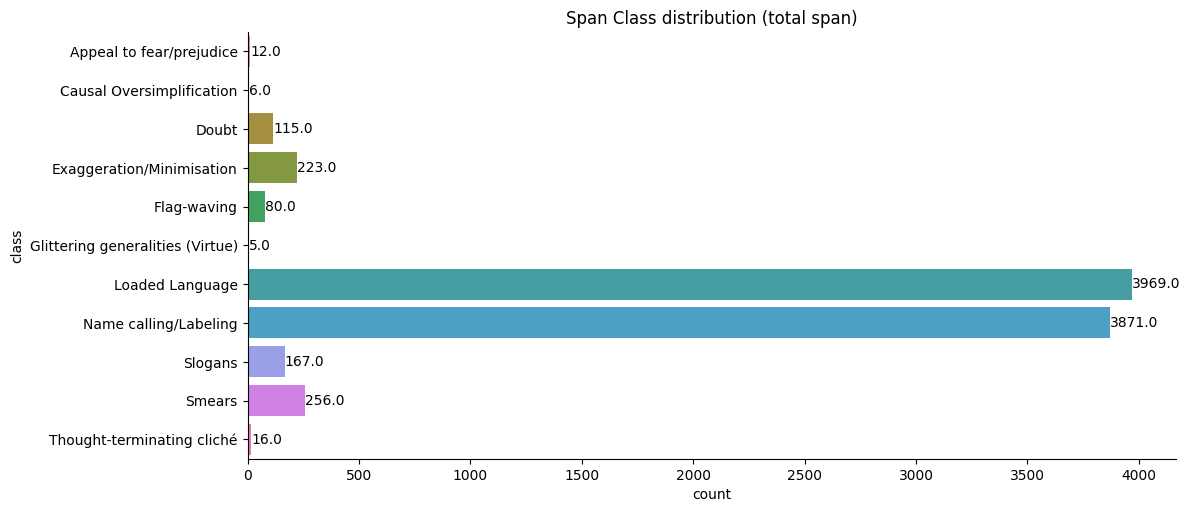

In [150]:
g=sns.catplot(data=span_record.sort_values('class'), y="class", kind="count", hue='class', legend=False)
g.fig.set_size_inches(20,5)
ax = g.facet_axis(0, 0)
for c in ax.containers:
    labels = [f'{v.get_width()}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')
plt.title("Span Class distribution (total span)")
plt.show()

## Persuasion vs Sentiment

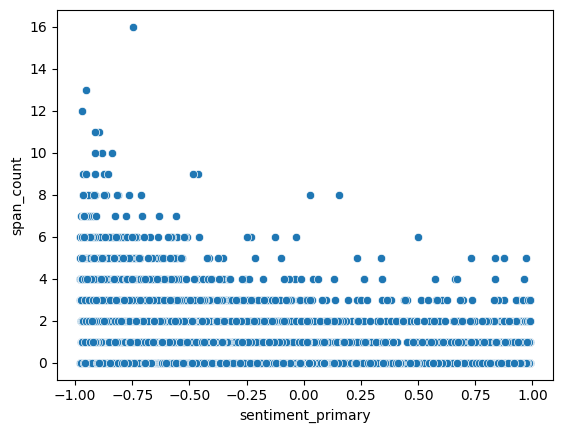

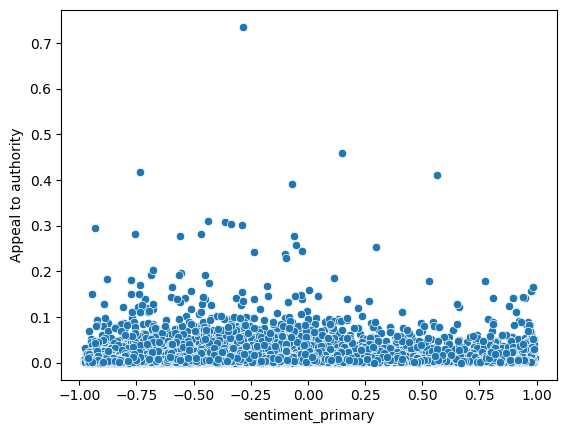

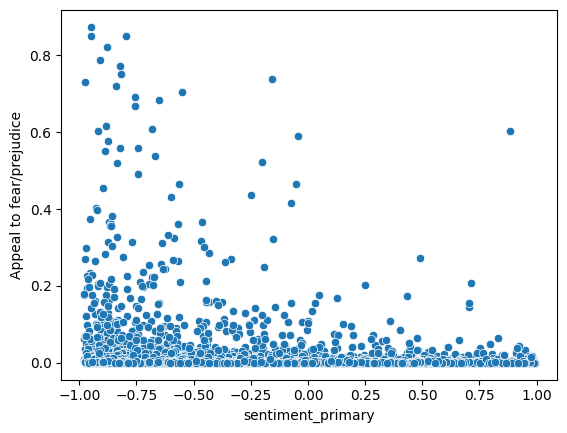

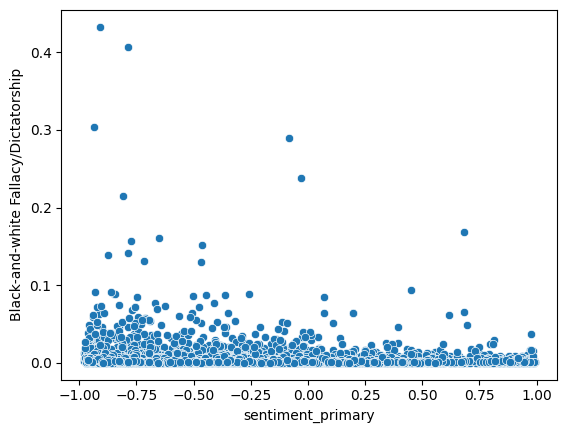

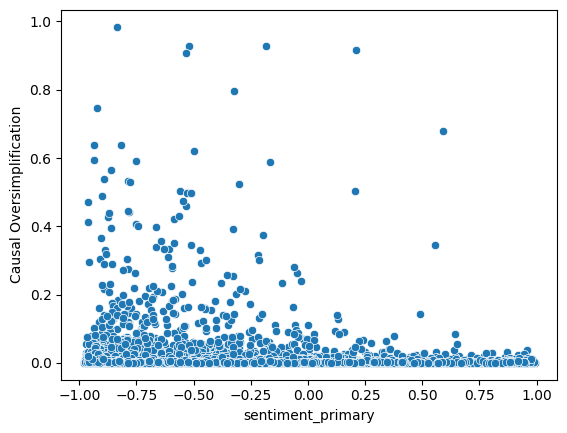

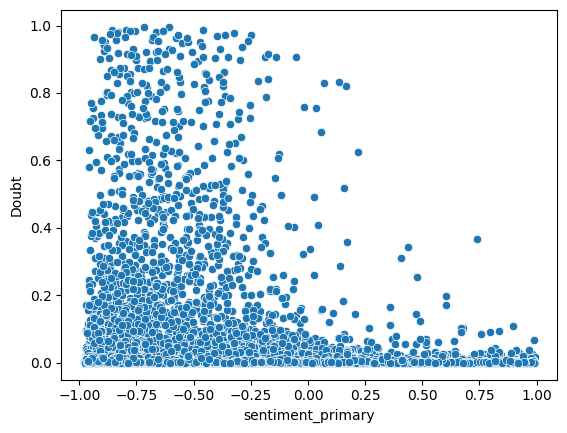

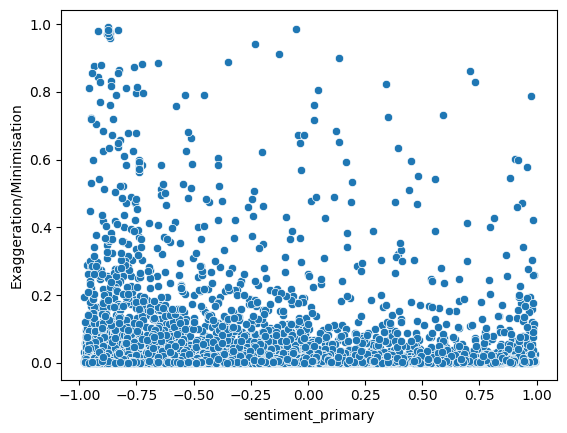

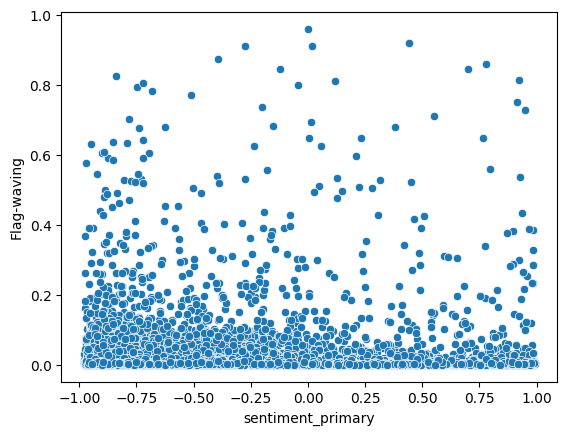

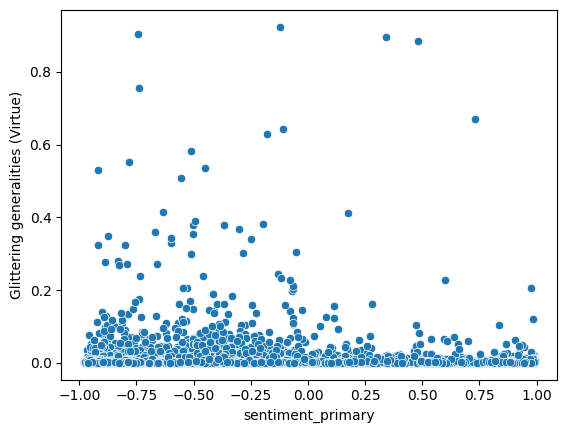

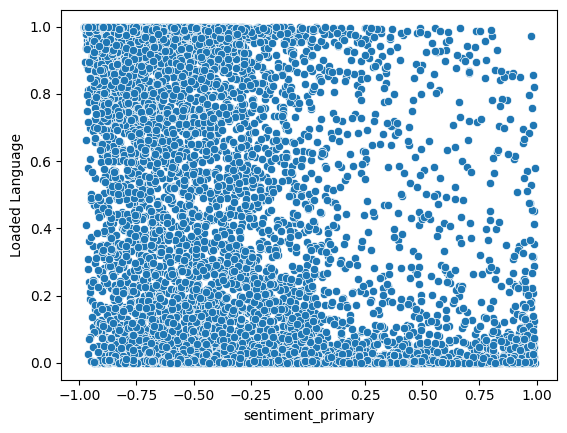

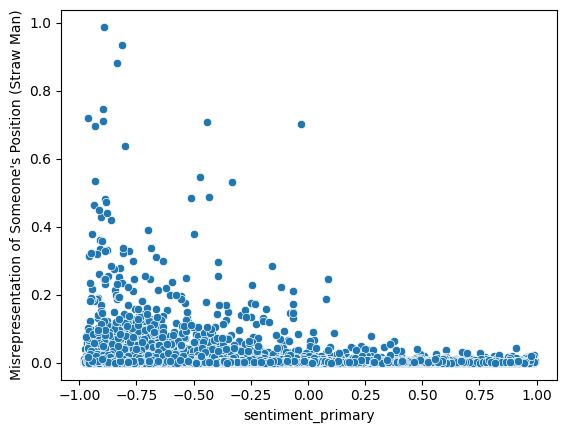

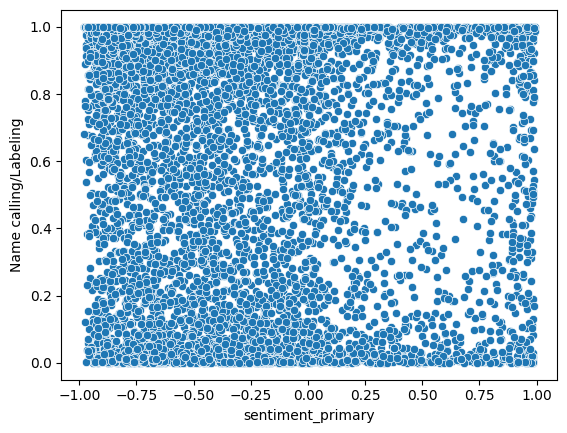

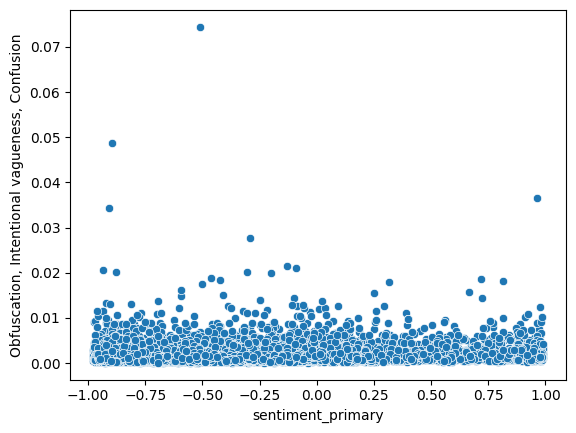

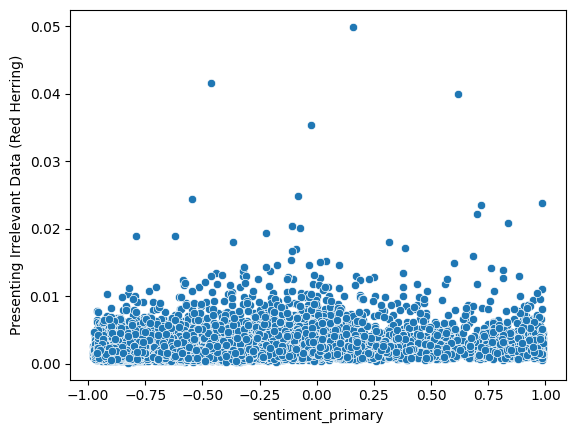

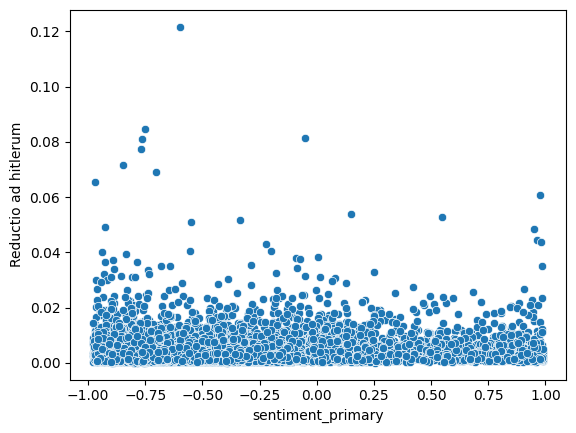

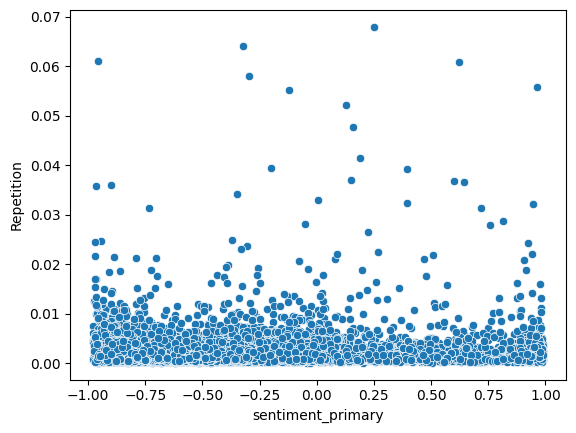

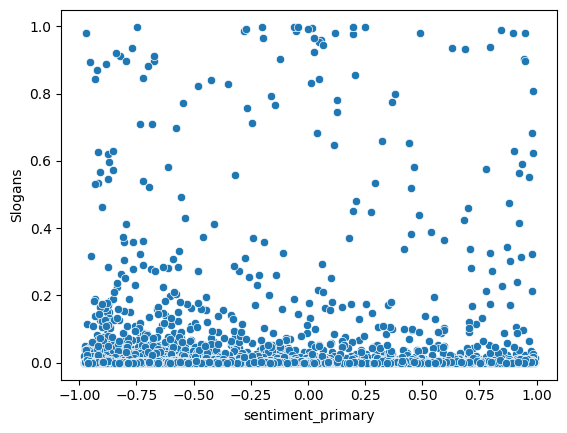

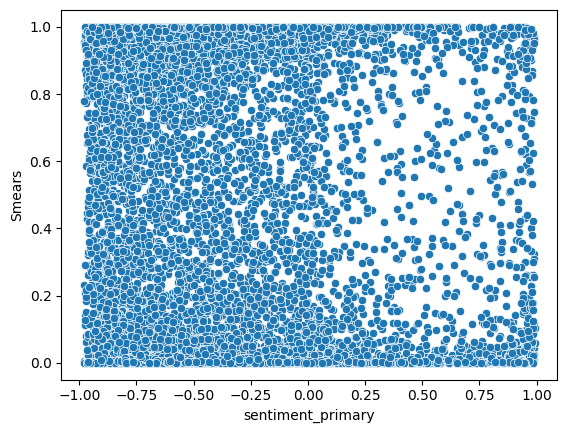

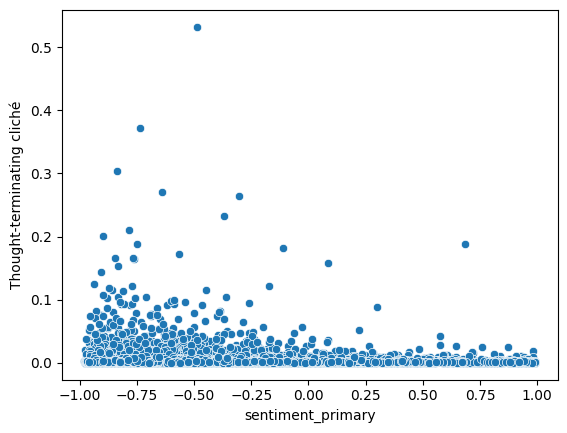

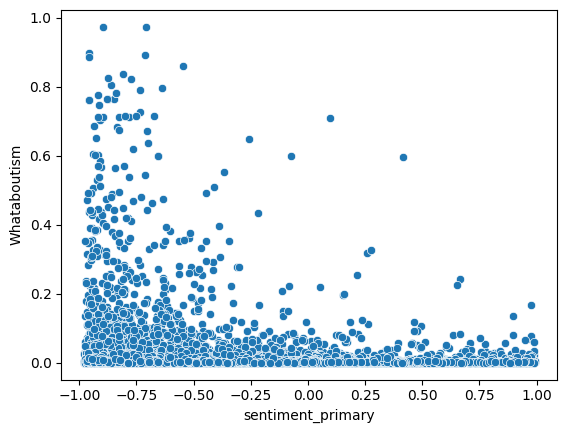

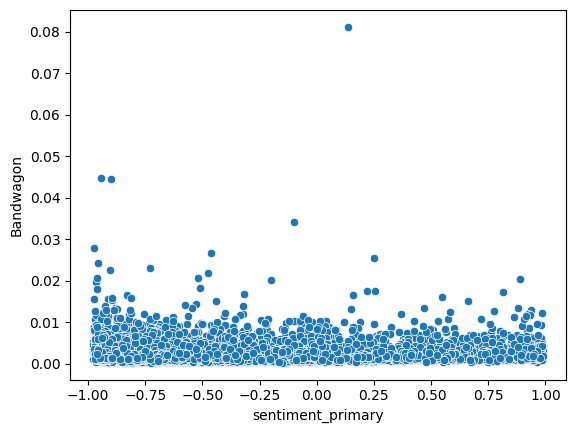

In [241]:
sns.scatterplot(data=data_frame[data_frame["span_count"] < 30], x="sentiment_primary", y="span_count")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Appeal to authority")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Appeal to fear/prejudice")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Black-and-white Fallacy/Dictatorship")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Causal Oversimplification")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Doubt")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Exaggeration/Minimisation")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Flag-waving")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Glittering generalities (Virtue)")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Loaded Language")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Misrepresentation of Someone's Position (Straw Man)")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Name calling/Labeling")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Obfuscation, Intentional vagueness, Confusion")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Presenting Irrelevant Data (Red Herring)")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Reductio ad hitlerum")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Repetition")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Slogans")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Smears")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Thought-terminating cliché")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Whataboutism")
plt.show()
sns.scatterplot(data=data_frame, x="sentiment_primary", y="Bandwagon")
plt.show()

## Between class correlation

<Axes: >

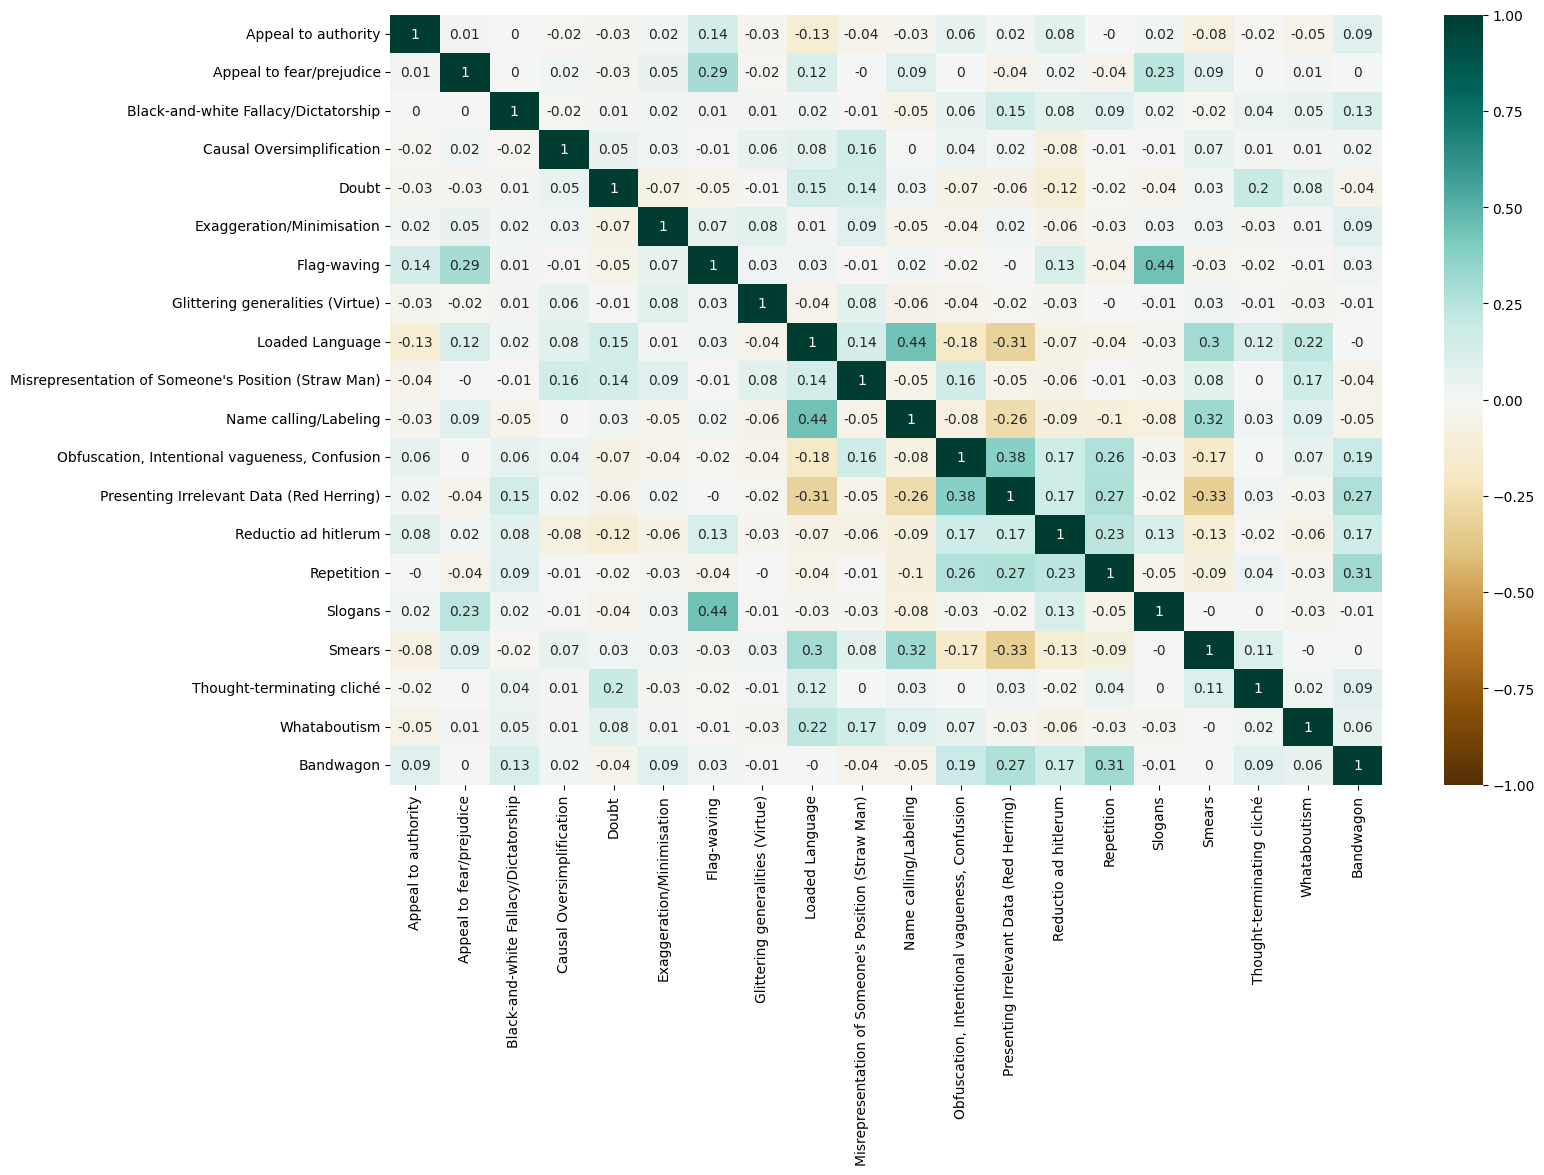

In [152]:
plt.figure(figsize=(16, 10))
class_matrix = data_frame.iloc[:, 10:]
class_corr = class_matrix.corr()
sns.heatmap(class_corr.round(2), vmin=-1, vmax=1, annot=True, cmap='BrBG')

### Top 5 negative between-class correlation

In [153]:
class_links = class_corr.stack().reset_index()
class_links.columns = ['var1', 'var2', 'value']
class_links = class_links[class_links['var1'] < class_links['var2']]
class_links[class_links['value'] != 1].sort_values(by=['value']).iloc[:5, :]


,var1,var2,value
256,Presenting Irrelevant Data (Red Herring),Smears,-0.326110
172,Loaded Language,Presenting Irrelevant Data (Red Herring),-0.306248
212,Name calling/Labeling,Presenting Irrelevant Data (Red Herring),-0.262586
171,Loaded Language,"Obfuscation, Intentional vagueness, Confusion",-0.177278
236,"Obfuscation, Intentional vagueness, Confusion",Smears,-0.172169


### Top 5 positive between-class correlation

In [154]:
print("Top positive between-class correlation 5")
class_links[class_links['value'] != 1].sort_values(by=['value']).iloc[-5:, :]

Top positive between-class correlation 5


,var1,var2,value
394,Bandwagon,Repetition,0.306392
216,Name calling/Labeling,Smears,0.324827
232,"Obfuscation, Intentional vagueness, Confusion",Presenting Irrelevant Data (Red Herring),0.380736
170,Loaded Language,Name calling/Labeling,0.437128
135,Flag-waving,Slogans,0.444790


## Visualize span

In [191]:
categories

['Appeal to authority',
 'Appeal to fear/prejudice',
 'Black-and-white Fallacy/Dictatorship',
 'Causal Oversimplification',
 'Doubt',
 'Exaggeration/Minimisation',
 'Flag-waving',
 'Glittering generalities (Virtue)',
 'Loaded Language',
 "Misrepresentation of Someone's Position (Straw Man)",
 'Name calling/Labeling',
 'Obfuscation, Intentional vagueness, Confusion',
 'Presenting Irrelevant Data (Red Herring)',
 'Reductio ad hitlerum',
 'Repetition',
 'Slogans',
 'Smears',
 'Thought-terminating cliché',
 'Whataboutism',
 'Bandwagon']

#### Grab the span of particular class

In [265]:
span_record[span_record['class'] == categories[1]].head()

,data_index,class,size,text
2082,2315,Appeal to fear/prejudice,16,This mafia country must be kicked out of NATO ...
2949,3297,Appeal to fear/prejudice,14,Every country needs a baseline of anti corrupt...
3629,4028,Appeal to fear/prejudice,11,Keep in Mind Russian Missiles can reach North ...
3674,4076,Appeal to fear/prejudice,15,Why does anything going on in Biafra justify R...
4271,4735,Appeal to fear/prejudice,12,almost every mass murderer has been white and ...


In [ ]:
sorted_data = data_frame[data_frame['span_count'] > 0].sort_values(by=['sentiment_primary'])
sorted_data.head()

In [156]:
from spacy import displacy
colors = {'Appeal to authority': "#ed6161",
 'Appeal to fear/prejudice': "#ed6184",
 'Black-and-white Fallacy/Dictatorship': "#ed61ba",
 'Causal Oversimplification': "#ed61d3",
 'Doubt': "#e761ed",
 'Exaggeration/Minimisation': "#cc61ed",
 'Flag-waving': "#ad61ed",
 'Glittering generalities (Virtue)': "#8361ed",
 'Loaded Language': "#6166ed",
 "Misrepresentation of Someone's Position (Straw Man)": "#618bed",
 'Name calling/Labeling': "#61c6ed",
 'Obfuscation, Intentional vagueness, Confusion': "#61e3ed",
 'Presenting Irrelevant Data (Red Herring)': "#61edcb",
 'Reductio ad hitlerum': "#61edaf",
 'Repetition': "#61ed81",
 'Slogans': "#63ed61",
 'Smears': "#8ded61",
 'Thought-terminating cliché': "#b5ed61",
 'Whataboutism': "#e1ed61",
 'Bandwagon': "#edb961"}
option = {"colors": colors}

In [ ]:
sorted_data.index

### Negative

In [ ]:
displacy.render(span_doc_list[4774], style="span", options = option, jupyter=True)

In [ ]:
displacy.render(span_doc_list[575], style="span", options = option, jupyter=True)

### Positive

In [ ]:
displacy.render(span_doc_list[5880], options = option, style="span", jupyter=True)

In [ ]:
displacy.render(span_doc_list[104], options = option, style="span", jupyter=True)

In [ ]:
displacy.render(span_doc_list[4993], style="span", options = option, jupyter=True)

### Dubious

In [ ]:
displacy.render(span_doc_list[3824], style="span", options = option, jupyter=True)

In [ ]:
displacy.render(span_doc_list[4993], style="span", options = option, jupyter=True)

In [ ]:
displacy.render(span_doc_list[4028], style="span", options = option, jupyter=True)

In [ ]:
displacy.render(span_doc_list[6225], style="span", options = option, jupyter=True)

## Demo

In [4]:
text = "Greedy corporate is sucking us dry!"

In [ ]:
span_doc = nlp2(text)

In [262]:
displacy.render(span_doc, options = option, style="span", jupyter=True)

In [263]:
doc = nlp(text)
doc.cats

{'Appeal to authority': 0.0017711373511701822,
 'Appeal to fear/prejudice': 0.009320873767137527,
 'Black-and-white Fallacy/Dictatorship': 0.0024220473133027554,
 'Causal Oversimplification': 0.0007490555290132761,
 'Doubt': 0.06613308936357498,
 'Exaggeration/Minimisation': 0.0010874117724597454,
 'Flag-waving': 0.018073664978146553,
 'Glittering generalities (Virtue)': 0.0038979612290859222,
 'Loaded Language': 0.9994679093360901,
 "Misrepresentation of Someone's Position (Straw Man)": 0.0005476126680150628,
 'Name calling/Labeling': 0.9995874762535095,
 'Obfuscation, Intentional vagueness, Confusion': 0.0003087245859205723,
 'Presenting Irrelevant Data (Red Herring)': 0.0007248194888234138,
 'Reductio ad hitlerum': 0.002691408386453986,
 'Repetition': 0.0025065455120056868,
 'Slogans': 0.001453471020795405,
 'Smears': 0.11957187950611115,
 'Thought-terminating cliché': 0.0002801255031954497,
 'Whataboutism': 0.001842980389483273,
 'Bandwagon': 0.0008057868108153343}